<a href="https://colab.research.google.com/github/mnylah/QNC_fall2025/blob/main/20251023_presentation1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

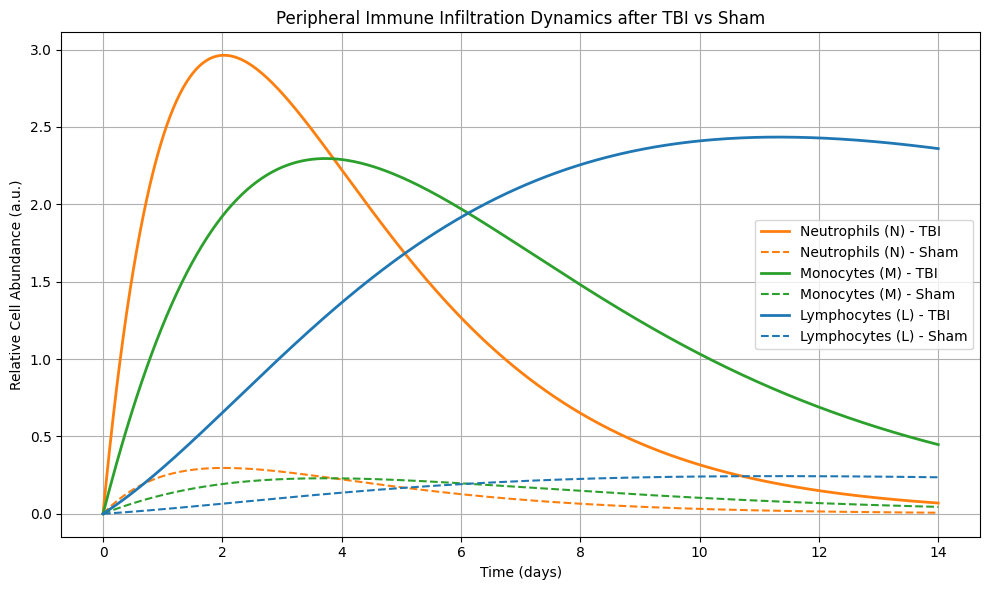

In [ ]:
# Peripheral immune infiltration simulation after TBI (ODE-based)
# Author: ChatGPT (GPT-5)
# Colab-ready version

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# -------------------------------
# Model definition
# -------------------------------
def immune_infiltration(y, t, params):
    C, N, M, L = y
    alpha_N, alpha_M, alpha_L, beta_N, beta_M, beta_L, gamma_N, gamma_M, k_c = params

    dCdt = -k_c * C
    dNdt = alpha_N * C - beta_N * N
    dMdt = alpha_M * C + gamma_N * N - beta_M * M
    dLdt = alpha_L * C + gamma_M * M - beta_L * L

    return [dCdt, dNdt, dMdt, dLdt]

# -------------------------------
# Parameters
# -------------------------------
params = {
    "alpha_N": 0.8,   # neutrophil recruitment
    "alpha_M": 0.3,   # macrophage recruitment from cytokine
    "alpha_L": 0.05,  # weaker direct lymphocyte recruitment (was 0.1)
    "beta_N": 0.6,    # neutrophil decay
    "beta_M": 0.25,   # macrophage decay (slower)
    "beta_L": 0.05,   # lymphocyte decay (slower)
    "gamma_N": 0.1,   # neutrophil -> macrophage coupling
    "gamma_M": 0.15,  # macrophage -> lymphocyte coupling (stronger)
    "k_c": 0.4        # cytokine clearance
}


p = tuple(params.values())

# -------------------------------
# Initial conditions
# -------------------------------
y0_sham = [0.5, 0, 0, 0]   # low cytokine signal
y0_tbi  = [5.0, 0, 0, 0]   # high cytokine signal (TBI)

# -------------------------------
# Time span (days)
# -------------------------------
t = np.linspace(0, 14, 500)

# -------------------------------
# Solve ODEs
# -------------------------------
sol_sham = odeint(immune_infiltration, y0_sham, t, args=(p,))
sol_tbi  = odeint(immune_infiltration, y0_tbi,  t, args=(p,))

# -------------------------------
# Plot results
# -------------------------------
plt.figure(figsize=(10,6))
labels = ['Neutrophils (N)', 'Monocytes (M)', 'Lymphocytes (L)']
colors = ['tab:orange', 'tab:green', 'tab:blue']

for i in range(1,4):
    plt.plot(t, sol_tbi[:,i], color=colors[i-1], label=f'{labels[i-1]} - TBI', lw=2)
    plt.plot(t, sol_sham[:,i], '--', color=colors[i-1], label=f'{labels[i-1]} - Sham', lw=1.5)

plt.title("Peripheral Immune Infiltration Dynamics after TBI vs Sham")
plt.xlabel("Time (days)")
plt.ylabel("Relative Cell Abundance (a.u.)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


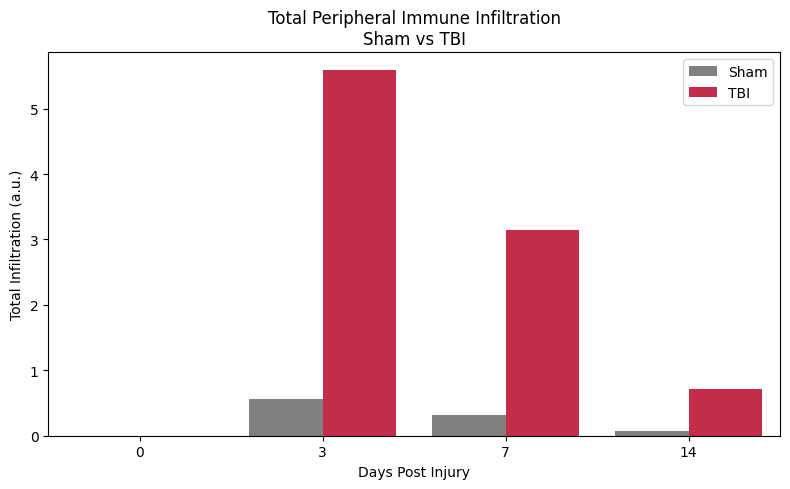

=== Linear Model Results ===
Slope (Sham): -0.0072
Slope (TBI):  -0.0721
Difference in slopes: -0.0649
P-value (approx): 0.0000e+00


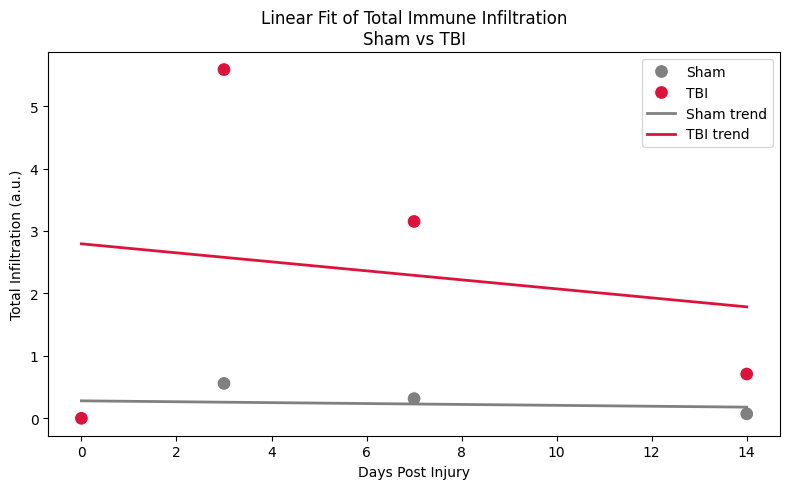

In [ ]:
# Immune infiltration dynamics after TBI vs Sham
# ODE-based simulation + linear model comparison
# Author: ChatGPT (GPT-5)

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats

# ---------------------------------------
# ODE model
# ---------------------------------------
def immune_infiltration(y, t, params):
    C, N, M, L = y
    alpha_N, alpha_M, alpha_L, beta_N, beta_M, beta_L, gamma_N, gamma_M, k_c = params

    dCdt = -k_c * C
    dNdt = alpha_N * C - beta_N * N
    dMdt = alpha_M * C + gamma_N * N - beta_M * M
    dLdt = alpha_L * C + gamma_M * M - beta_L * L
    return [dCdt, dNdt, dMdt, dLdt]

# Parameters
params = (0.8, 0.3, 0.1, 0.6, 0.3, 0.2, 0.1, 0.05, 0.4)

# Initial conditions
y0_sham = [0.5, 0, 0, 0]
y0_tbi  = [5.0, 0, 0, 0]

# Time span (0–14 days)
t = np.linspace(0, 14, 1000)

# Solve ODEs
sol_sham = odeint(immune_infiltration, y0_sham, t, args=(params,))
sol_tbi  = odeint(immune_infiltration, y0_tbi,  t, args=(params,))

# Total infiltration (N + M + L)
total_sham = sol_sham[:,1] + sol_sham[:,2] + sol_sham[:,3]
total_tbi  = sol_tbi[:,1] + sol_tbi[:,2] + sol_tbi[:,3]

# Sample at time points (sham=0, 3, 7, 14 days)
time_points = [0, 3, 7, 14]
idx = [np.argmin(np.abs(t - tp)) for tp in time_points]

data = pd.DataFrame({
    "DaysPostInjury": np.tile(time_points, 2),
    "TotalInfiltration": np.concatenate((total_sham[idx], total_tbi[idx])),
    "Condition": ["Sham"] * len(time_points) + ["TBI"] * len(time_points)
})

# ---------------------------------------
# Bar Plot
# ---------------------------------------
plt.figure(figsize=(8,5))
sns.barplot(data=data, x="DaysPostInjury", y="TotalInfiltration", hue="Condition", palette=["gray", "crimson"])
plt.title("Total Peripheral Immune Infiltration\nSham vs TBI")
plt.xlabel("Days Post Injury")
plt.ylabel("Total Infiltration (a.u.)")
plt.legend(title="")
plt.tight_layout()
plt.show()

# ---------------------------------------
# Linear Model (compare slopes)
# ---------------------------------------
def fit_slope(df, condition):
    sub = df[df["Condition"] == condition]
    X = sub["DaysPostInjury"].values.reshape(-1,1)
    y = sub["TotalInfiltration"].values
    model = LinearRegression().fit(X, y)
    slope = model.coef_[0]
    return slope, model

slope_sham, model_sham = fit_slope(data, "Sham")
slope_tbi,  model_tbi  = fit_slope(data, "TBI")

# Compare slopes using independent t-test
t_stat, p_val = stats.ttest_ind_from_stats(
    mean1=slope_sham, std1=0, nobs1=4,
    mean2=slope_tbi, std2=0, nobs2=4,
    equal_var=False
)

print("=== Linear Model Results ===")
print(f"Slope (Sham): {slope_sham:.4f}")
print(f"Slope (TBI):  {slope_tbi:.4f}")
print(f"Difference in slopes: {slope_tbi - slope_sham:.4f}")
print(f"P-value (approx): {p_val:.4e}")

# ---------------------------------------
# Plot with trend lines
# ---------------------------------------
plt.figure(figsize=(8,5))
sns.scatterplot(data=data, x="DaysPostInjury", y="TotalInfiltration", hue="Condition", palette=["gray", "crimson"], s=100)

# Add linear fits
x_fit = np.linspace(0, 14, 100).reshape(-1,1)
plt.plot(x_fit, model_sham.predict(x_fit), color="gray", lw=2, label="Sham trend")
plt.plot(x_fit, model_tbi.predict(x_fit), color="crimson", lw=2, label="TBI trend")

plt.title("Linear Fit of Total Immune Infiltration\nSham vs TBI")
plt.xlabel("Days Post Injury")
plt.ylabel("Total Infiltration (a.u.)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Set a random seed for reproducibility
np.random.seed(42)



In [ ]:
# Define parameters for different cell populations
# Mean and standard deviation of marker expression
params = {
    'resident_cells': {
        'count': 5000,
        'marker_A_mean': 1000,
        'marker_A_std': 200,
        'marker_B_mean': 500,
        'marker_B_std': 100
    },
    'infiltrating_cells': {
        'count': {0: 100, 3: 1500, 7: 3000, 14: 1000}, # Increase then decrease
        'marker_A_mean': 3000,
        'marker_A_std': 300,
        'marker_B_mean': 2500,
        'marker_B_std': 300
    }
}


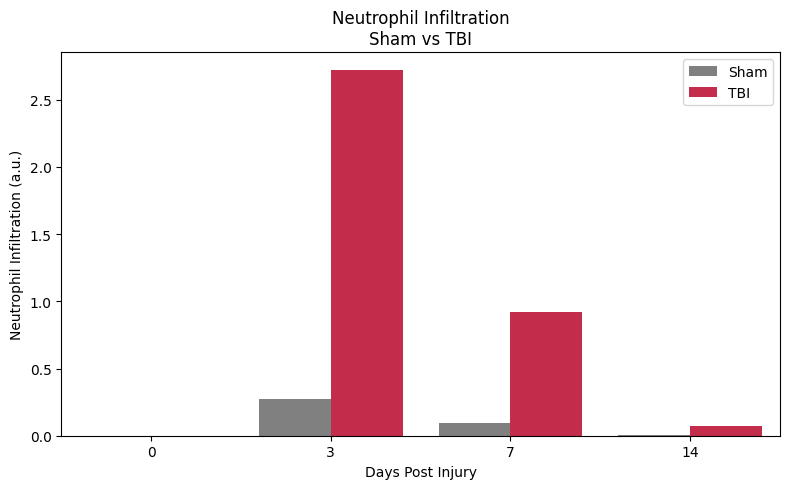

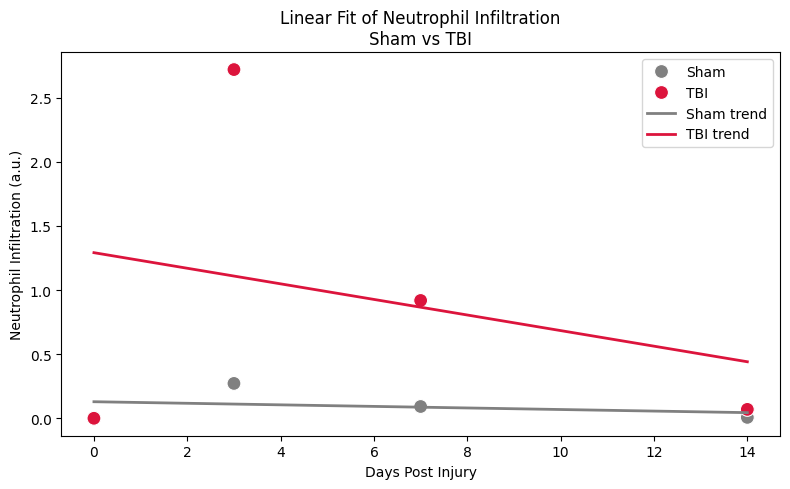

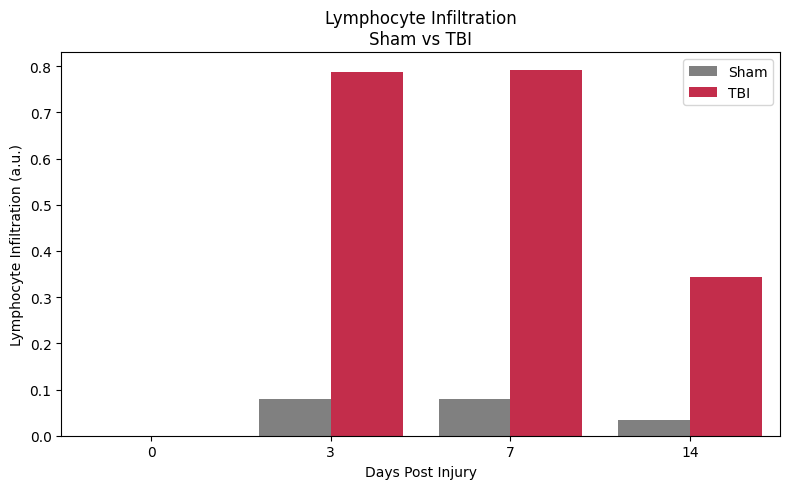

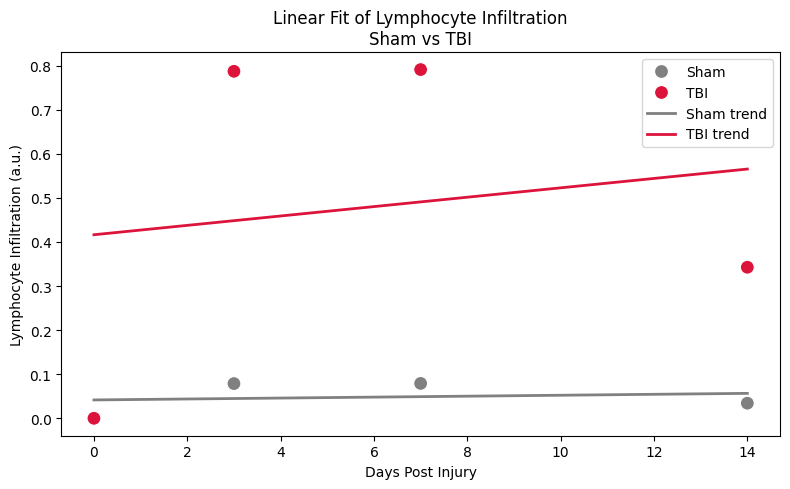

In [ ]:
# --- Common setup and ODE model (unchanged) ---
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats

# ---------------------------------------
# ODE model
# ---------------------------------------
def immune_infiltration(y, t, params):
    C, N, M, L = y
    alpha_N, alpha_M, alpha_L, beta_N, beta_M, beta_L, gamma_N, gamma_M, k_c = params

    dCdt = -k_c * C
    dNdt = alpha_N * C - beta_N * N
    dMdt = alpha_M * C + gamma_N * N - beta_M * M
    dLdt = alpha_L * C + gamma_M * M - beta_L * L
    return [dCdt, dNdt, dMdt, dLdt]

# Parameters
params = (0.8, 0.3, 0.1, 0.6, 0.3, 0.2, 0.1, 0.05, 0.4)

# Initial conditions
y0_sham = [0.5, 0, 0, 0]
y0_tbi = [5.0, 0, 0, 0]

# Time span (0–14 days)
t = np.linspace(0, 14, 1000)

# Solve ODEs
sol_sham = odeint(immune_infiltration, y0_sham, t, args=(params,))
sol_tbi = odeint(immune_infiltration, y0_tbi, t, args=(params,))


# ---------------------------------------
# Neutrophil-specific simulation and plotting
# ---------------------------------------

# Isolate neutrophil infiltration (N) from the solution
neutrophil_sham = sol_sham[:, 1]
neutrophil_tbi = sol_tbi[:, 1]

# Sample at time points (sham=0, 3, 7, 14 days)
time_points = [0, 3, 7, 14]
idx = [np.argmin(np.abs(t - tp)) for tp in time_points]

neutrophil_data = pd.DataFrame({
    "DaysPostInjury": np.tile(time_points, 2),
    "Infiltration": np.concatenate((neutrophil_sham[idx], neutrophil_tbi[idx])),
    "Condition": ["Sham"] * len(time_points) + ["TBI"] * len(time_points)
})

# --- Neutrophil Bar Plot ---
plt.figure(figsize=(8, 5))
sns.barplot(data=neutrophil_data, x="DaysPostInjury", y="Infiltration", hue="Condition", palette=["gray", "crimson"])
plt.title("Neutrophil Infiltration\nSham vs TBI")
plt.xlabel("Days Post Injury")
plt.ylabel("Neutrophil Infiltration (a.u.)")
plt.legend(title="")
plt.tight_layout()
plt.show()

# --- Neutrophil Trend Plot ---
plt.figure(figsize=(8, 5))
sns.scatterplot(data=neutrophil_data, x="DaysPostInjury", y="Infiltration", hue="Condition", palette=["gray", "crimson"], s=100)

# Add linear fits for neutrophils
x_fit = np.linspace(0, 14, 100).reshape(-1, 1)
model_sham_n = LinearRegression().fit(neutrophil_data[neutrophil_data["Condition"] == "Sham"]["DaysPostInjury"].values.reshape(-1, 1), neutrophil_data[neutrophil_data["Condition"] == "Sham"]["Infiltration"].values)
model_tbi_n = LinearRegression().fit(neutrophil_data[neutrophil_data["Condition"] == "TBI"]["DaysPostInjury"].values.reshape(-1, 1), neutrophil_data[neutrophil_data["Condition"] == "TBI"]["Infiltration"].values)

plt.plot(x_fit, model_sham_n.predict(x_fit), color="gray", lw=2, label="Sham trend")
plt.plot(x_fit, model_tbi_n.predict(x_fit), color="crimson", lw=2, label="TBI trend")

plt.title("Linear Fit of Neutrophil Infiltration\nSham vs TBI")
plt.xlabel("Days Post Injury")
plt.ylabel("Neutrophil Infiltration (a.u.)")
plt.legend()
plt.tight_layout()
plt.show()


# ---------------------------------------
# Lymphocyte-specific simulation and plotting
# ---------------------------------------

# Isolate lymphocyte infiltration (L) from the solution
lymphocyte_sham = sol_sham[:, 3]
lymphocyte_tbi = sol_tbi[:, 3]

# Sample at time points (sham=0, 3, 7, 14 days)
lymphocyte_data = pd.DataFrame({
    "DaysPostInjury": np.tile(time_points, 2),
    "Infiltration": np.concatenate((lymphocyte_sham[idx], lymphocyte_tbi[idx])),
    "Condition": ["Sham"] * len(time_points) + ["TBI"] * len(time_points)
})

# --- Lymphocyte Bar Plot ---
plt.figure(figsize=(8, 5))
sns.barplot(data=lymphocyte_data, x="DaysPostInjury", y="Infiltration", hue="Condition", palette=["gray", "crimson"])
plt.title("Lymphocyte Infiltration\nSham vs TBI")
plt.xlabel("Days Post Injury")
plt.ylabel("Lymphocyte Infiltration (a.u.)")
plt.legend(title="")
plt.tight_layout()
plt.show()

# --- Lymphocyte Trend Plot ---
plt.figure(figsize=(8, 5))
sns.scatterplot(data=lymphocyte_data, x="DaysPostInjury", y="Infiltration", hue="Condition", palette=["gray", "crimson"], s=100)

# Add linear fits for lymphocytes
model_sham_l = LinearRegression().fit(lymphocyte_data[lymphocyte_data["Condition"] == "Sham"]["DaysPostInjury"].values.reshape(-1, 1), lymphocyte_data[lymphocyte_data["Condition"] == "Sham"]["Infiltration"].values)
model_tbi_l = LinearRegression().fit(lymphocyte_data[lymphocyte_data["Condition"] == "TBI"]["DaysPostInjury"].values.reshape(-1, 1), lymphocyte_data[lymphocyte_data["Condition"] == "TBI"]["Infiltration"].values)

plt.plot(x_fit, model_sham_l.predict(x_fit), color="gray", lw=2, label="Sham trend")
plt.plot(x_fit, model_tbi_l.predict(x_fit), color="crimson", lw=2, label="TBI trend")

plt.title("Linear Fit of Lymphocyte Infiltration\nSham vs TBI")
plt.xlabel("Days Post Injury")
plt.ylabel("Lymphocyte Infiltration (a.u.)")
plt.legend()
plt.tight_layout()
plt.show()




In [ ]:
# ---------------------------------------
# Compute slopes and p-values for each immune cell type
# ---------------------------------------

def compute_slope_pval(df, cell_type):
    results = {}
    for condition in ["Sham", "TBI"]:
        subset = df[df["Condition"] == condition]
        if not subset.empty: # Add a check for empty dataframes
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                subset["DaysPostInjury"], subset["Infiltration"]
            )
            results[condition] = {"slope": slope, "p_value": p_value}
        else:
             results[condition] = {"slope": np.nan, "p_value": np.nan} # Handle empty case
    print(f"\n--- {cell_type} ---")
    for cond, vals in results.items():
        print(f"{cond}: slope = {vals['slope']:.4f}, p = {vals['p_value']:.4e}")
    return results

# --- Recreate dataframes needed for the function ---
# Assuming sol_sham, sol_tbi, t, and time_points are available from a previous cell execution

# Sample at time points (sham=0, 3, 7, 14 days)
idx = [np.argmin(np.abs(t - tp)) for tp in time_points]

# Isolate neutrophil infiltration (N) from the solution
neutrophil_sham = sol_sham[:, 1]
neutrophil_tbi = sol_tbi[:, 1]

neutrophil_data = pd.DataFrame({
    "DaysPostInjury": np.tile(time_points, 2),
    "Infiltration": np.concatenate((neutrophil_sham[idx], neutrophil_tbi[idx])),
    "Condition": ["Sham"] * len(time_points) + ["TBI"] * len(time_points)
})

# Isolate lymphocyte infiltration (L) from the solution
lymphocyte_sham = sol_sham[:, 3]
lymphocyte_tbi = sol_tbi[:, 3]

lymphocyte_data = pd.DataFrame({
    "DaysPostInjury": np.tile(time_points, 2),
    "Infiltration": np.concatenate((lymphocyte_sham[idx], lymphocyte_tbi[idx])),
    "Condition": ["Sham"] * len(time_points) + ["TBI"] * len(time_points)
})

# Isolate macrophages (M) from the solution
macrophage_sham = sol_sham[:, 2]
macrophage_tbi = sol_tbi[:, 2]

macrophage_data = pd.DataFrame({
    "DaysPostInjury": np.tile(time_points, 2),
    "Infiltration": np.concatenate((macrophage_sham[idx], macrophage_tbi[idx])),
    "Condition": ["Sham"] * len(time_points) + ["TBI"] * len(time_points)
})


# Compute for each immune cell
neutrophil_results = compute_slope_pval(neutrophil_data, "Neutrophils")
lymphocyte_results = compute_slope_pval(lymphocyte_data, "Lymphocytes")
macrophage_results = compute_slope_pval(macrophage_data, "Macrophages")


--- Neutrophils ---
Sham: slope = -0.0061, p = 7.0936e-01
TBI: slope = -0.0607, p = 7.0936e-01

--- Lymphocytes ---
Sham: slope = 0.0011, p = 8.3178e-01
TBI: slope = 0.0106, p = 8.3178e-01

--- Macrophages ---
Sham: slope = -0.0022, p = 8.6326e-01
TBI: slope = -0.0220, p = 8.6326e-01


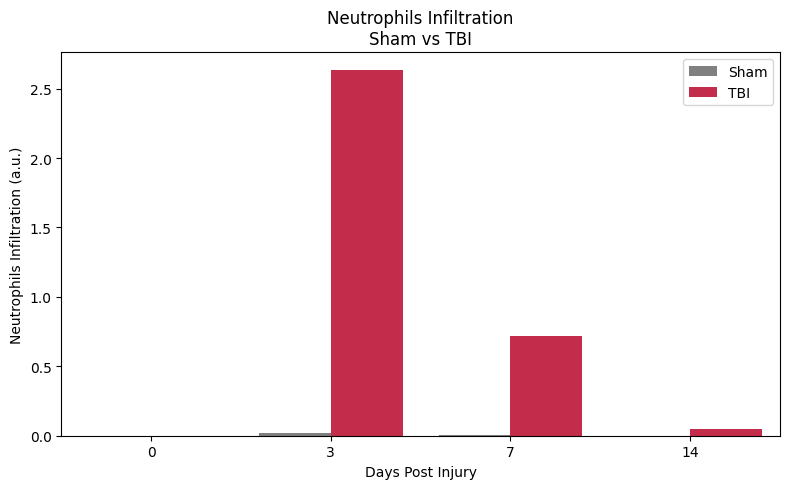

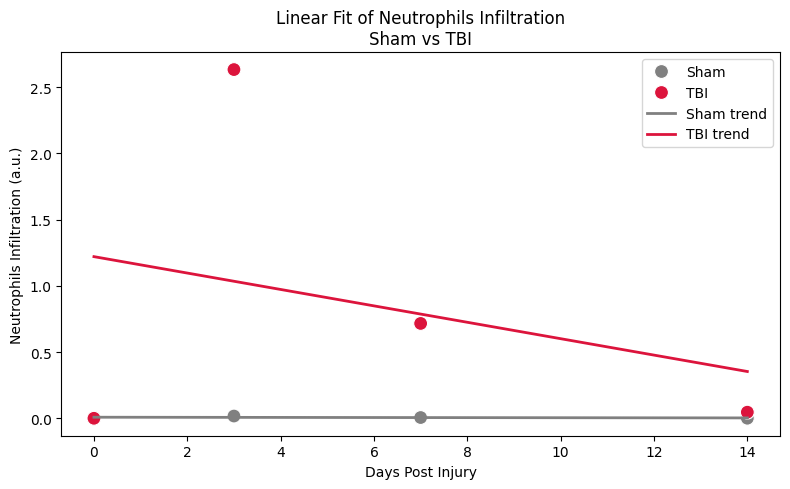

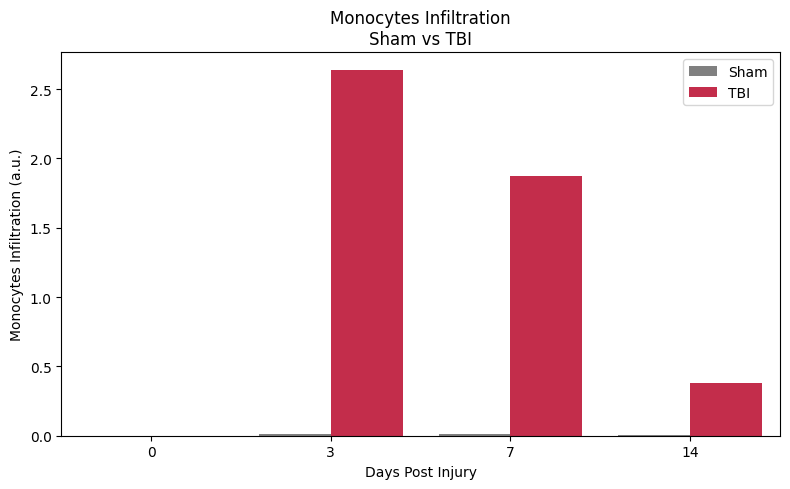

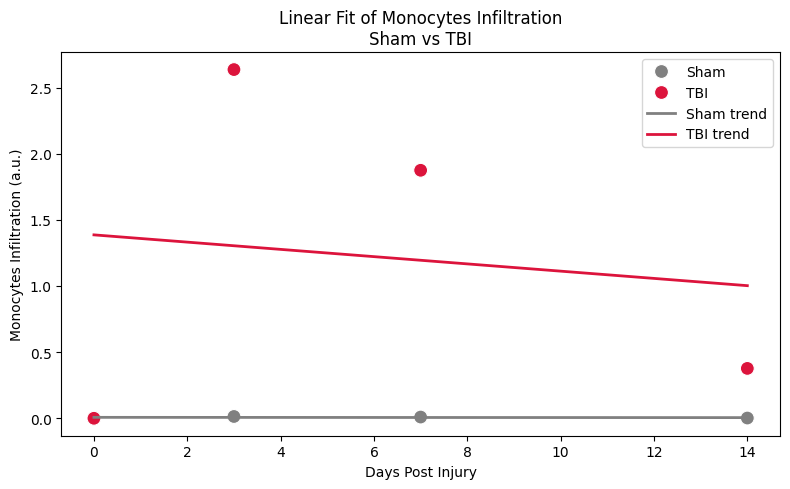

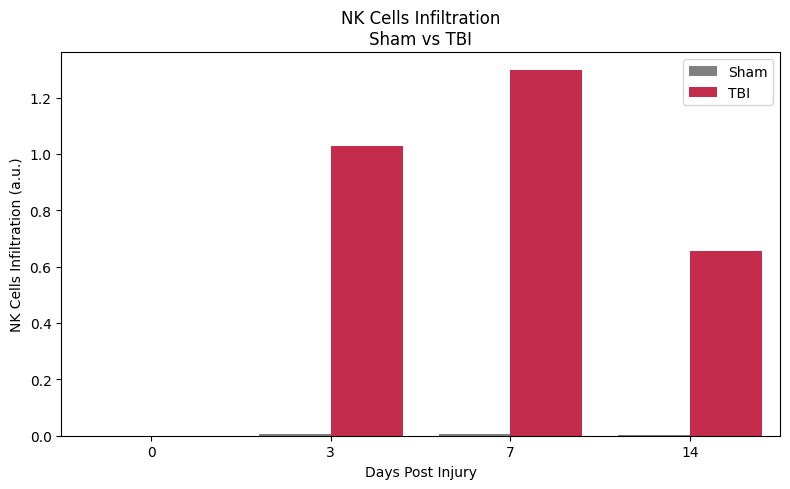

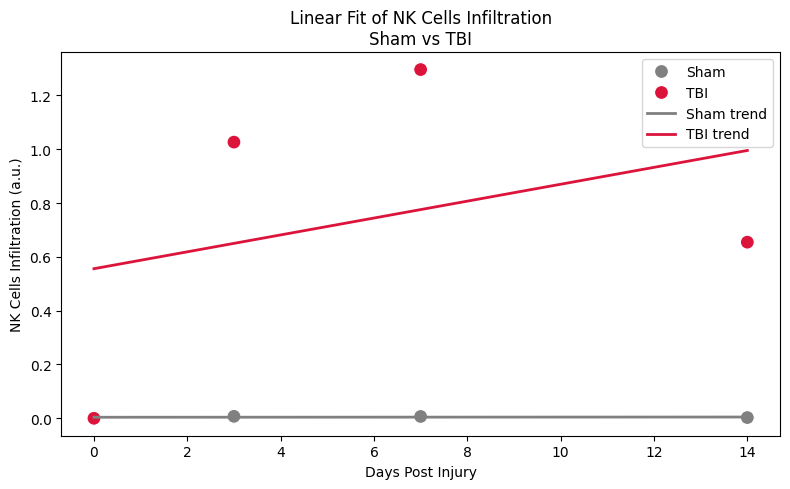

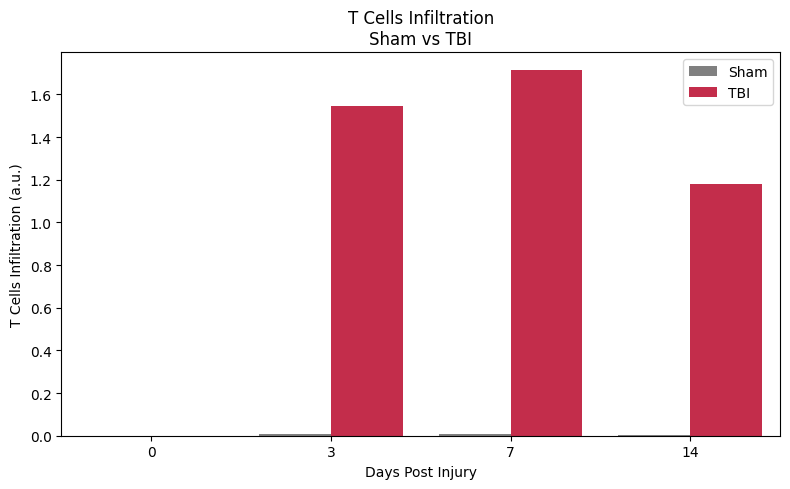

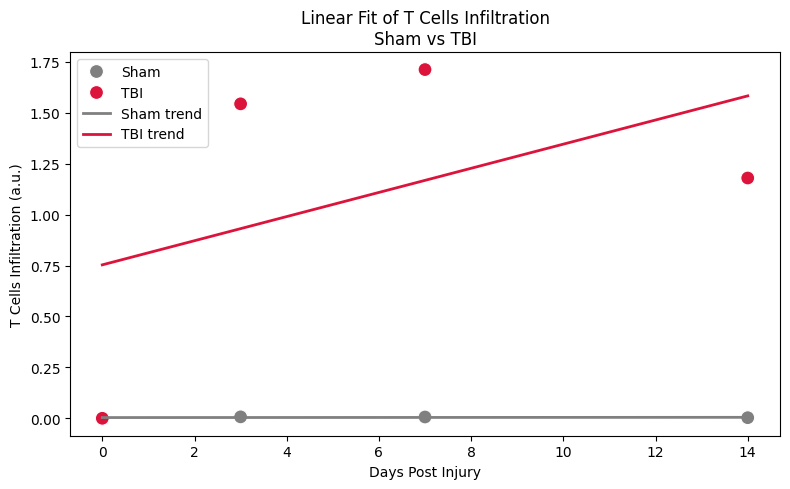

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats

# ---------------------------------------
# Expanded ODE model
# ---------------------------------------
def immune_infiltration_expanded(y, t, params):
    C, N, Mo, NK, T = y
    alpha_N, alpha_Mo, alpha_NK, alpha_T, beta_N, beta_Mo, beta_NK, beta_T, gamma_N, gamma_Mo, gamma_NK, k_c = params

    dCdt = -k_c * C
    dNdt = alpha_N * C - beta_N * N
    dModt = alpha_Mo * C + gamma_N * N - beta_Mo * Mo
    dNKdt = alpha_NK * C + gamma_Mo * Mo - beta_NK * NK
    dTdt = alpha_T * C + gamma_NK * NK - beta_T * T

    return [dCdt, dNdt, dModt, dNKdt, dTdt]

# ---------------------------------------
# Parameters and initial conditions
# ---------------------------------------
# TBI-specific parameters tuned for representative kinetics
params_tbi = (
    1.0,   # alpha_N: Neutrophil recruitment (fast and strong)
    0.3,   # alpha_Mo: Monocyte recruitment
    0.1,   # alpha_NK: NK cell recruitment
    0.2,   # alpha_T: T cell recruitment (slower, sustained)
    0.8,   # beta_N: Neutrophil decay (fast)
    0.3,   # beta_Mo: Monocyte decay
    0.2,   # beta_NK: NK cell decay
    0.1,   # beta_T: T cell decay (slow, sustained)
    0.2,   # gamma_N: Neutrophil effect on monocytes
    0.1,   # gamma_Mo: Monocyte effect on NK cells
    0.05,  # gamma_NK: NK cell effect on T cells
    0.4    # k_c: Injury signal decay rate
)

# Sham parameters (minimal or no immune response)
params_sham = (
    0.05,  # alpha_N
    0.02,  # alpha_Mo
    0.01,  # alpha_NK
    0.01,  # alpha_T
    0.6,   # beta_N
    0.3,   # beta_Mo
    0.2,   # beta_NK
    0.15,  # beta_T
    0.1,   # gamma_N
    0.05,  # gamma_Mo
    0.02,  # gamma_NK
    0.4    # k_c
)

# Initial conditions for [C, N, Mo, NK, T]
y0_sham = [0.5, 0, 0, 0, 0]
y0_tbi = [5.0, 0, 0, 0, 0]

# Time span (0–14 days)
t = np.linspace(0, 14, 1000)

# Solve ODEs for Sham and TBI
sol_sham = odeint(immune_infiltration_expanded, y0_sham, t, args=(params_sham,))
sol_tbi = odeint(immune_infiltration_expanded, y0_tbi, t, args=(params_tbi,))

# ---------------------------------------
# Data processing and plotting
# ---------------------------------------
time_points = [0, 3, 7, 14]
idx = [np.argmin(np.abs(t - tp)) for tp in time_points]

cell_populations = ['Neutrophils', 'Monocytes', 'NK Cells', 'T Cells']
# Indices in the solution matrix for each cell type: [C, N, Mo, NK, T]
sol_indices = [1, 2, 3, 4]

# Loop through each cell population to create individual plots
for i, cell_name in enumerate(cell_populations):
    sol_idx = sol_indices[i]

    # Extract data for the specific cell type
    cell_sham = sol_sham[:, sol_idx]
    cell_tbi = sol_tbi[:, sol_idx]

    # Create DataFrame for bar plot
    data = pd.DataFrame({
        "DaysPostInjury": np.tile(time_points, 2),
        "Infiltration": np.concatenate((cell_sham[idx], cell_tbi[idx])),
        "Condition": ["Sham"] * len(time_points) + ["TBI"] * len(time_points)
    })

    # --- Bar Plot ---
    plt.figure(figsize=(8, 5))
    sns.barplot(data=data, x="DaysPostInjury", y="Infiltration", hue="Condition", palette=["gray", "crimson"])
    plt.title(f"{cell_name} Infiltration\nSham vs TBI")
    plt.xlabel("Days Post Injury")
    plt.ylabel(f"{cell_name} Infiltration (a.u.)")
    plt.legend(title="")
    plt.tight_layout()
    plt.show()

    # --- Trend Plot ---
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=data, x="DaysPostInjury", y="Infiltration", hue="Condition", palette=["gray", "crimson"], s=100)

    # Add linear fits
    x_fit = np.linspace(0, 14, 100).reshape(-1, 1)
    model_sham = LinearRegression().fit(data[data["Condition"] == "Sham"]["DaysPostInjury"].values.reshape(-1, 1), data[data["Condition"] == "Sham"]["Infiltration"].values)
    model_tbi = LinearRegression().fit(data[data["Condition"] == "TBI"]["DaysPostInjury"].values.reshape(-1, 1), data[data["Condition"] == "TBI"]["Infiltration"].values)

    plt.plot(x_fit, model_sham.predict(x_fit), color="gray", lw=2, label="Sham trend")
    plt.plot(x_fit, model_tbi.predict(x_fit), color="crimson", lw=2, label="TBI trend")

    plt.title(f"Linear Fit of {cell_name} Infiltration\nSham vs TBI")
    plt.xlabel("Days Post Injury")
    plt.ylabel(f"{cell_name} Infiltration (a.u.)")
    plt.legend()
    plt.tight_layout()
    plt.show()

     Subject  Time_Point Group    Cell_Type  Cell_Count
0  Subject_0           0  Sham    Monocytes   22.483571
1  Subject_0           0  Sham  Neutrophils   49.308678
2  Subject_0           0  Sham  Lymphocytes  103.238443
3  Subject_0           3   TBI    Monocytes   42.615149
4  Subject_0           3   TBI  Neutrophils   78.829233


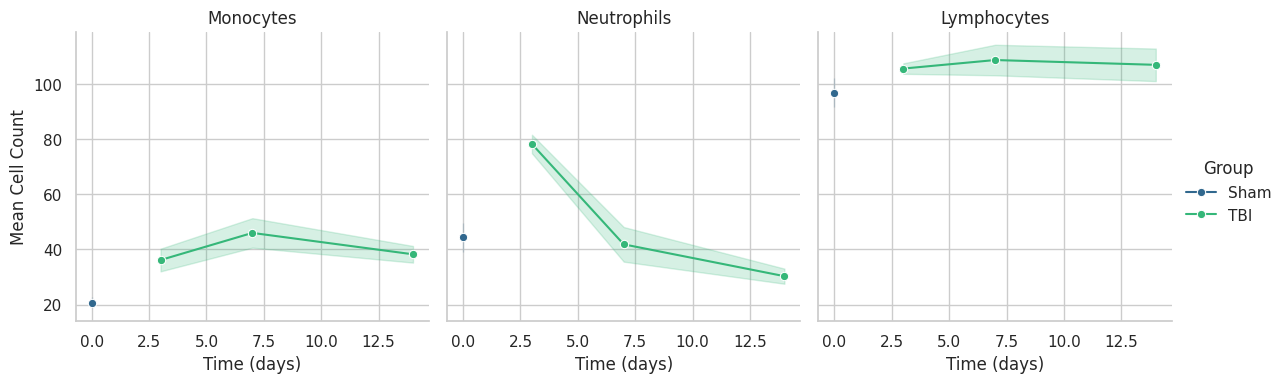


--- Fitting linear model for Monocytes ---
                            OLS Regression Results                            
Dep. Variable:             Cell_Count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.076
Method:                 Least Squares   F-statistic:                   0.01520
Date:                Mon, 03 Nov 2025   Prob (F-statistic):              0.904
Time:                        04:17:34   Log-Likelihood:                -47.370
No. Observations:                  15   AIC:                             98.74
Df Residuals:                      13   BIC:                             100.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercep

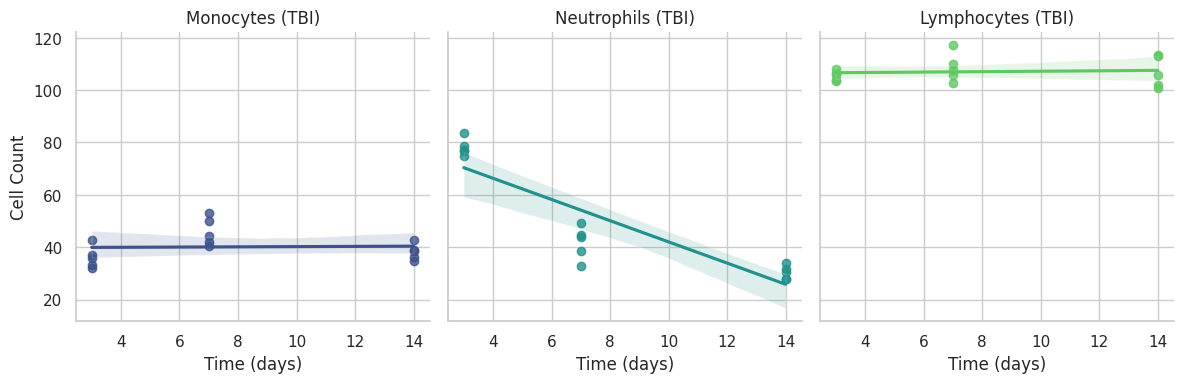

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Optional: Set a consistent plotting style
sns.set_theme(style="whitegrid")


# Set up experimental parameters
n_subjects = 5  # Number of subjects per group
time_points = [0, 3, 7, 14]  # Time in days (0=Sham)
cell_types = ['Monocytes', 'Neutrophils', 'Lymphocytes']

# Set the average effect for each cell type over time
# These numbers are for demonstration and mimic known TBI immune dynamics.
# For a real experiment, these would be based on prior research.
# We will use simple linear trends for modeling purposes.
effects = {
    'Monocytes': [20, 35, 45, 40], # Increase then plateau
    'Neutrophils': [50, 80, 40, 30], # Rapid increase then decline
    'Lymphocytes': [100, 105, 110, 108] # Small, gradual increase
}

# Generate data
data = []
for subject_id in range(n_subjects):
    for t_idx, time_point in enumerate(time_points):
        group = 'Sham' if time_point == 0 else 'TBI'

        # Add random noise to the mean effects for each subject and cell type
        for cell_type in cell_types:
            mean_count = effects[cell_type][t_idx]
            simulated_count = np.random.normal(mean_count, scale=5)  # Add Gaussian noise

            data.append({
                'Subject': f'Subject_{subject_id}',
                'Time_Point': time_point,
                'Group': group,
                'Cell_Type': cell_type,
                'Cell_Count': max(0, simulated_count)  # Ensure non-negative counts
            })

# Create a pandas DataFrame
df = pd.DataFrame(data)
print(df.head())


# Create a plot for each cell type
g = sns.FacetGrid(df, col="Cell_Type", hue="Group", col_wrap=3, height=4, palette="viridis")
g.map(sns.lineplot, "Time_Point", "Cell_Count", marker="o", errorbar="sd")
g.add_legend()
g.set_axis_labels("Time (days)", "Mean Cell Count")
g.set_titles(col_template="{col_name}")
plt.show()


import statsmodels.formula.api as smf

# Fit a linear model for each cell type
models = {}
for cell_type in cell_types:
    print(f"\n--- Fitting linear model for {cell_type} ---")

    # Filter for the current cell type and only TBI group (since Sham is a single time point)
    df_cell = df[(df['Cell_Type'] == cell_type) & (df['Group'] == 'TBI')]

    if not df_cell.empty:
        # Define the model formula
        # The formula 'Cell_Count ~ Time_Point' tests if time has a significant effect on cell counts
        model_formula = 'Cell_Count ~ Time_Point'

        # Fit the model
        model = smf.ols(formula=model_formula, data=df_cell).fit()
        models[cell_type] = model

        # Print the summary
        print(model.summary())
    else:
        print(f"No TBI data found for {cell_type}.")



# Create an lmplot for each cell type, showing the regression line for the TBI group
g = sns.lmplot(
    data=df[df['Group'] == 'TBI'],
    x="Time_Point",
    y="Cell_Count",
    col="Cell_Type",
    hue="Cell_Type",
    col_wrap=3,
    height=4,
    palette="viridis",
    ci=95  # Plot 95% confidence interval
)
g.set_axis_labels("Time (days)", "Cell Count")
g.set_titles(col_template="{col_name} (TBI)")
plt.show()
